## Chapter 4: Classification - Lab

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import statsmodels.api as sm
from ISLP import confusion_table, load_data
from ISLP.models import (contrast, ModelSpec as MS, summarize)
from sklearn.discriminant_analysis import (LinearDiscriminantAnalysis as LDA,
                                           QuadraticDiscriminantAnalysis as QDA)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
import seaborn as sns

In this lab we will examine the `Smarket` data, which is part of the `ISLP` library. This data set consists of percentage returns for the S&P 500 stock index over 1,250 days, from the beginning of 2001 until the end of 2005. For each date, we have recorded the percentage returns for each of the five previous trading days, `Lag1` through `Lag5`. We have also recorded `Volume` (the number of shares traded on the previous day, in billions), `Today` (the percentage return on the date in question) and `Direction` (whether the market was Up or Down on this date).

In [2]:
Smarket = load_data('Smarket')

In [3]:
Smarket.head()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
0,2001,0.381,-0.192,-2.624,-1.055,5.010,1.1913,0.959,Up
1,2001,0.959,0.381,-0.192,-2.624,-1.055,1.2965,1.032,Up
2,2001,1.032,0.959,0.381,-0.192,-2.624,1.4112,-0.623,Down
3,2001,-0.623,1.032,0.959,0.381,-0.192,1.2760,0.614,Up
4,2001,0.614,-0.623,1.032,0.959,0.381,1.2057,0.213,Up


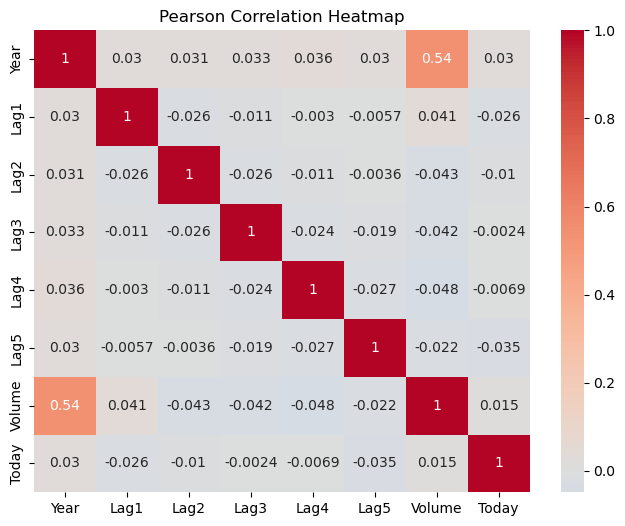

In [4]:
# Compute the Pearson correlation matrix for numerical predictors:
correlation_matrix = Smarket[Smarket.columns.drop('Direction')].corr()

# Create a heatmap using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Pearson Correlation Heatmap')
plt.show()

As one would expect, the correlations between the lagged return variables and today’s return are close to zero. The only substantial correlation is between `Year` and `Volume`.

<Axes: >

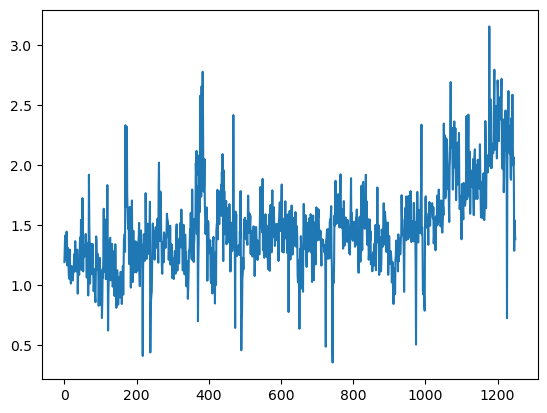

In [5]:
Smarket['Volume'].plot()

#### 4.7.2 Logistic Regression

Next, we will ft a logistic regression model in order to predict `Direction` using `Lag1` through `Lag5` and `Volume`.

The `sm.GLM()` function fits _generalized linear models_, a class of models that includes logistic regression. The syntax of `sm.GLM()` is similar to that of `sm.OLS()`, except that we must pass in the argument `family=sm.families.Binomial()` in order to tell statsmodels to run a logistic regression rather than some other type of generalized linear model.

In [6]:
allvars = Smarket.columns.drop(['Today', 'Direction', 'Year'])
design = MS(allvars)
X = design.fit_transform(Smarket)
# We are predicting whether Direction is Up
y = Smarket['Direction'] == 'Up'
glm = sm.GLM(y, X, family=sm.families.Binomial())
results = glm.fit()
print(results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              Direction   No. Observations:                 1250
Model:                            GLM   Df Residuals:                     1243
Model Family:                Binomial   Df Model:                            6
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -863.79
Date:                Sat, 19 Aug 2023   Deviance:                       1727.6
Time:                        07:31:58   Pearson chi2:                 1.25e+03
No. Iterations:                     4   Pseudo R-squ. (CS):           0.002868
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.1260      0.241     -0.523      0.6

The smallest p-value here is associated with `Lag1`. The negative coefficient for this predictor suggests that if the market had a positive return yesterday, then it is less likely to go up today. However, at a value of 0.15, the p-value is still relatively large, and so there is no clear evidence of a real association between `Lag1` and `Direction`.

If no data set is supplied to the `predict()` function, then it returns the probabilities computer for the training data:

In [7]:
probs = results.predict()
probs[:10]

array([0.50708413, 0.48146788, 0.48113883, 0.51522236, 0.51078116,
       0.50695646, 0.49265087, 0.50922916, 0.51761353, 0.48883778])

In [8]:
labels = np.array(['Down'] * 1250)
labels[probs > 0.5] = "Up"

In [9]:
print(confusion_matrix(labels, Smarket['Direction']))

[[145 141]
 [457 507]]


In [10]:
# Use the confusion_table function to display a nicer table
confusion_table(labels, Smarket['Direction'])

Truth,Down,Up
Predicted,,
Down,145,141
Up,457,507


In [11]:
# Fraction of days on which prediction was correct
np.mean(labels == Smarket['Direction'])

0.5216

This corresponds to a training error rate of about 48%, but is probably optimistic and underestimates the test error rate.

In order to better assess the accuracy of the logistic regression model in this setting, we can fit the model using part of the data, and then examine how well it predicts the held out data. This will yield a more realistic error rate, in the sense that in practice we will be interested in our model’s performance not on the data that we used to ft the model, but rather on days in the future for which the market’s movements are unknown.

To implement this strategy, we frst create a Boolean vector corresponding to the observations from 2001 through 2004. We then use this vector to create a held out data set of observations from 2005.

In [12]:
train = (Smarket['Year'] < 2005)
Smarket_train = Smarket.loc[train]
Smarket_test = Smarket.loc[~train]
Smarket_test.shape

(252, 9)

In [13]:
X_train, X_test = X.loc[train], X.loc[~train]
y_train, y_test = y.loc[train], y.loc[~train]
glm_train = sm.GLM(y_train, X_train, family=sm.families.Binomial())
results = glm_train.fit()
probs = results.predict(exog=X_test)

In [14]:
# Store the test and traning labels
D = Smarket['Direction']
L_train, L_test = D.loc[train], D.loc[~train]

In [15]:
# Threhold the fitted probability at 50% to form predicted labels
labels = np.array(['Down'] * 252)
labels[probs > 0.5] = 'Up'

In [16]:
# Produce the confusion matrix of predictions and actual values for test set
confusion_table(labels, L_test)

Truth,Down,Up
Predicted,,
Down,77,97
Up,34,44


In [17]:
# Produce a tuple of accuracy and error rates
np.mean(labels == L_test), np.mean(labels != L_test)

(0.4801587301587302, 0.5198412698412699)

This is worse than guessing, but one would not expect to be able to use the previous days' returns to predict future market performance.

Using predictors that have no relationship with the response tends to cause a deterioration in the test error rate (since such predictors cause an increase in variance without a corresponding decrease in bias), and so removing such predictors may in turn yield an improvement. Below we reft the logistic regression using just `Lag1` and `Lag2`, which seemed to have the highest predictive power in the original logistic regression model.

In [20]:
model = MS(['Lag1', 'Lag2']).fit(Smarket)
X = model.transform(Smarket)
X_train, X_test = X.loc[train], X.loc[~train]
glm_train = sm.GLM(y_train, X_train, family=sm.families.Binomial())
results = glm_train.fit()
probs = results.predict(exog=X_test)
labels = np.array(['Down'] * 252)
labels[probs > 0.5] = 'Up'
confusion_table(labels, L_test)

Truth,Down,Up
Predicted,,
Down,35,35
Up,76,106


In [21]:
# Produce a tuple of accuracy and error rates
np.mean(labels == L_test), np.mean(labels != L_test)

(0.5595238095238095, 0.44047619047619047)

By removing all but `Lag1` and `Lag2`, we now seem to do a little better than chance. 

Suppose that we want to predict the returns associated with particular values of `Lag1` and `Lag2`. In particular, we want to predict probability of `Direction` = "Up" on a day when `Lag1` and `Lag2` equal 1.2 and 1.1, respectively, and on a day when they equal 1.5 and −0.8.

In [22]:
newdata = pd.DataFrame({
    'Lag1':[1.2, 1.5],
    'Lag2':[1.1, -0.8]
})

newX = model.transform(newdata)
results.predict(newX)

0    0.479146
1    0.496094
dtype: float64

#### 4.7.3 Linear Discriminant Analysis

We perform LDA on the `Smarket` data using `LinearDiscriminantAnalysis()`.

In [35]:
lda = LDA(store_covariance=True)

Since the `LDA` estimator automatically adds an intercept, we should remove the column corresponding to the intercept in both `X_train` and `X_test`.

We can also directly use the labels rather than the Boolean vectors `y_train`.

In [37]:
X_train, X_test = [M.drop(columns=['intercept']) for M in [X_train, X_test]]
lda.fit(X_train, L_train)

LinearDiscriminantAnalysis(store_covariance=True)

The average value of each predictor within each class suggest that there is a tendency for the previous 2 days' returns to be negative on days when the market increases, and a tendency for the previous days' returns to be positive on days when the market declines:

In [39]:
lda.classes_

array(['Down', 'Up'], dtype='<U4')

In [38]:
lda.means_

array([[ 0.04279022,  0.03389409],
       [-0.03954635, -0.03132544]])

In [40]:
lda.priors_

array([0.49198397, 0.50801603])

The linear discriminant vectors can be found in the `scalings_` attribute.

These values provide the linear combination of `Lag1` and `Lag2` that are used to form the LDA decision rule. If −0.64 × `Lag1` − 0.51 × `Lag2` is large, then the `LDA` classifer will predict a market increase, and if it is small, then the `LDA` classifer will predict a market decline.

In [41]:
lda.scalings_

array([[-0.64201904],
       [-0.51352928]])

In [42]:
lda_pred = lda.predict(X_test)

In [43]:
confusion_table(lda_pred, L_test)

Truth,Down,Up
Predicted,,
Down,35,35
Up,76,106


Comparing confusion matrices shows that our logistic regression and LDA predictions are almost identical.

We can also estimate the probability of each class for each point in the test dataset by applying a threshold of 50% to the poterior probabilities of being in class 'Up':

In [45]:
lda_prod = lda.predict_proba(X_test)

In [49]:
# Check that probability predictions for test datapoints and in agreement with probability predictions
lda_prob = lda.predict_proba(X_test)
np.all(np.where(lda_prob[:,1] >= 0.5, 'Up','Down') == lda_pred)

True

In [52]:
# Version of the above which works with multiple classes
np.all([lda.classes_[i] for i in np.argmax(lda_prob, 1)] == lda_pred)

True

#### 4.7.4 Quadratic Discriminant Analysis